In [1]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
all_seasons = []

for season in range(2020, 2023):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
      playerId    skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009       Zdeno Chara            D          127       20        0   
1      8466138      Joe Thornton            C           78       20        0   
2      8466139   Patrick Marleau            C           56        5        0   
3      8469455      Jason Spezza            C          125       33        0   
4      8469459       Mikko Koivu            C            7        1        0   
...        ...               ...          ...          ...      ...      ...   
1233   8483808   Andrei Kuzmenko            L           81       35        2   
1234   8484125     Hunter McKown            C           12        2        0   
1235   8484254      Akito Hirose            D            7        3        0   
1236   8484256  Jake Livingstone            D            5 

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
start_season = "20202021"
end_season = "20222023"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,Joe Thornton,78,1,3,1,10,68,7.27,91,72,36,5,110,10
2,Jason Spezza,125,3,4,7,22,178,17.16,243,155,66,13,313,24
6,Eric Staal,125,3,2,8,19,188,21.77,253,206,106,11,328,28
7,Jeff Carter,209,10,11,11,49,493,51.65,618,450,236,36,781,89
8,Dustin Brown,113,5,5,6,26,275,30.32,364,241,122,12,445,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,Matty Beniers,90,6,4,8,27,166,22.91,244,174,85,13,306,14
755,Cole Sillinger,143,3,5,6,19,241,27.17,338,276,115,7,433,36
758,Wyatt Johnston,82,4,4,8,24,160,18.92,207,192,94,8,281,35
759,Mason McTavish,89,2,6,5,19,173,22.67,231,174,92,8,285,35


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning
0,8466138,Joe Thornton,C,78,20,0,1,744.77870,1
1,8469455,Jason Spezza,C,125,33,0,3,653.25985,3
2,8470595,Eric Staal,C,125,23,1,2,868.72430,1
3,8470604,Jeff Carter,C,209,55,2,5,958.84570,3
4,8470606,Dustin Brown,R,113,33,0,1,970.80450,1
...,...,...,...,...,...,...,...,...,...
486,8482665,Matty Beniers,C,90,39,1,4,1020.96250,3
487,8482705,Cole Sillinger,C,143,23,0,3,810.29235,3
488,8482740,Wyatt Johnston,C,82,17,0,3,928.90240,3
489,8482745,Mason McTavish,C,89,27,0,2,853.62010,2


In [11]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [12]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,GP,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,8466138,Joe Thornton,C,78,20,0,1,744.77870,1,78.0,...,1.0,10.0,68.0,7.27,91.0,72.0,36.0,5.0,110.0,10.0
1,8469455,Jason Spezza,C,125,33,0,3,653.25985,3,125.0,...,7.0,22.0,178.0,17.16,243.0,155.0,66.0,13.0,313.0,24.0
2,8470595,Eric Staal,C,125,23,1,2,868.72430,1,125.0,...,8.0,19.0,188.0,21.77,253.0,206.0,106.0,11.0,328.0,28.0
3,8470604,Jeff Carter,C,209,55,2,5,958.84570,3,209.0,...,11.0,49.0,493.0,51.65,618.0,450.0,236.0,36.0,781.0,89.0
4,8470606,Dustin Brown,R,113,33,0,1,970.80450,1,113.0,...,6.0,26.0,275.0,30.32,364.0,241.0,122.0,12.0,445.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,8482665,Matty Beniers,C,90,39,1,4,1020.96250,3,90.0,...,8.0,27.0,166.0,22.91,244.0,174.0,85.0,13.0,306.0,14.0
487,8482705,Cole Sillinger,C,143,23,0,3,810.29235,3,143.0,...,6.0,19.0,241.0,27.17,338.0,276.0,115.0,7.0,433.0,36.0
488,8482740,Wyatt Johnston,C,82,17,0,3,928.90240,3,82.0,...,8.0,24.0,160.0,18.92,207.0,192.0,94.0,8.0,281.0,35.0
489,8482745,Mason McTavish,C,89,27,0,2,853.62010,2,89.0,...,5.0,19.0,173.0,22.67,231.0,174.0,92.0,8.0,285.0,35.0


In [13]:
merged_clutch_goals = merged_clutch_goals.fillna(0)
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, Rush Attempts, iCF, Rebounds Created]
Index: []

[0 rows x 22 columns]


In [17]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [18]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [19]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [20]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
335,Auston Matthews,15.33,1.0
284,Connor McDavid,13.44,2.0
240,Leon Draisaitl,13.33,3.0
254,David Pastrnak,13.27,4.0
321,Kirill Kaprizov,11.97,5.0
54,Max Pacioretty,10.98,6.0
400,Jason Robertson,10.87,7.0
14,Alex Ovechkin,10.72,8.0
291,Sebastian Aho,10.71,9.0
288,Mikko Rantanen,10.53,10.0


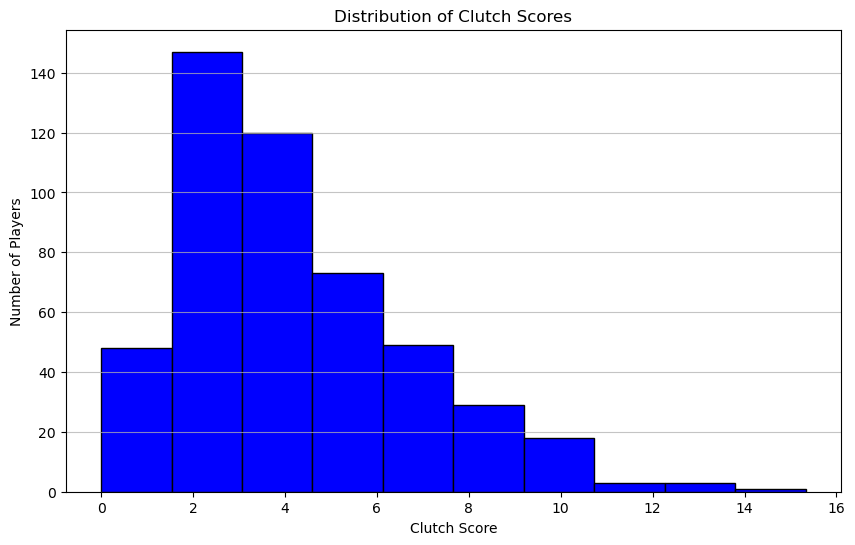

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

In [35]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [37]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    417
1     74
Name: count, dtype: int64

In [39]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [41]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.079096
score_time        0.023138
test_accuracy     0.888490
test_precision    0.737436
test_recall       0.653571
test_f1           0.629959
dtype: float64

C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise

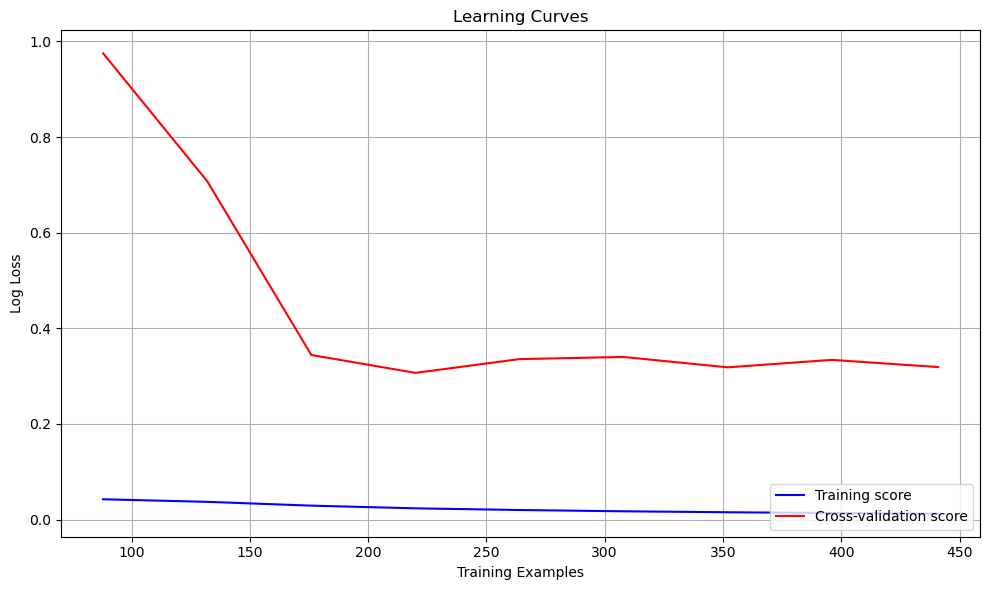

In [43]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

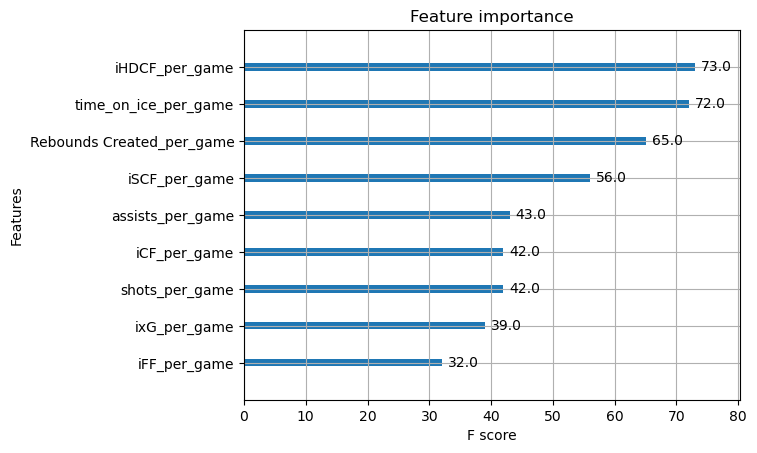

In [45]:
plot_importance(xgb_model)
plt.show()

In [47]:
x_var_adjusted = ['shots_per_game', 'ixG_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var_adjusted]

In [49]:
param_grid = {
    'max_depth': Integer(2,5),
    'min_child_weight': Integer(2,3), 
    'n_estimators': Integer(200, 300),
    'learning_rate': Real(0.03, 0.04), 
    'reg_alpha': Real(0.75, 1.9),
    'reg_lambda': Real(0.75, 1.9),
    'subsample': Real(0.7, 1), 
    'colsample_bytree': Real(0.7, 1)  
}

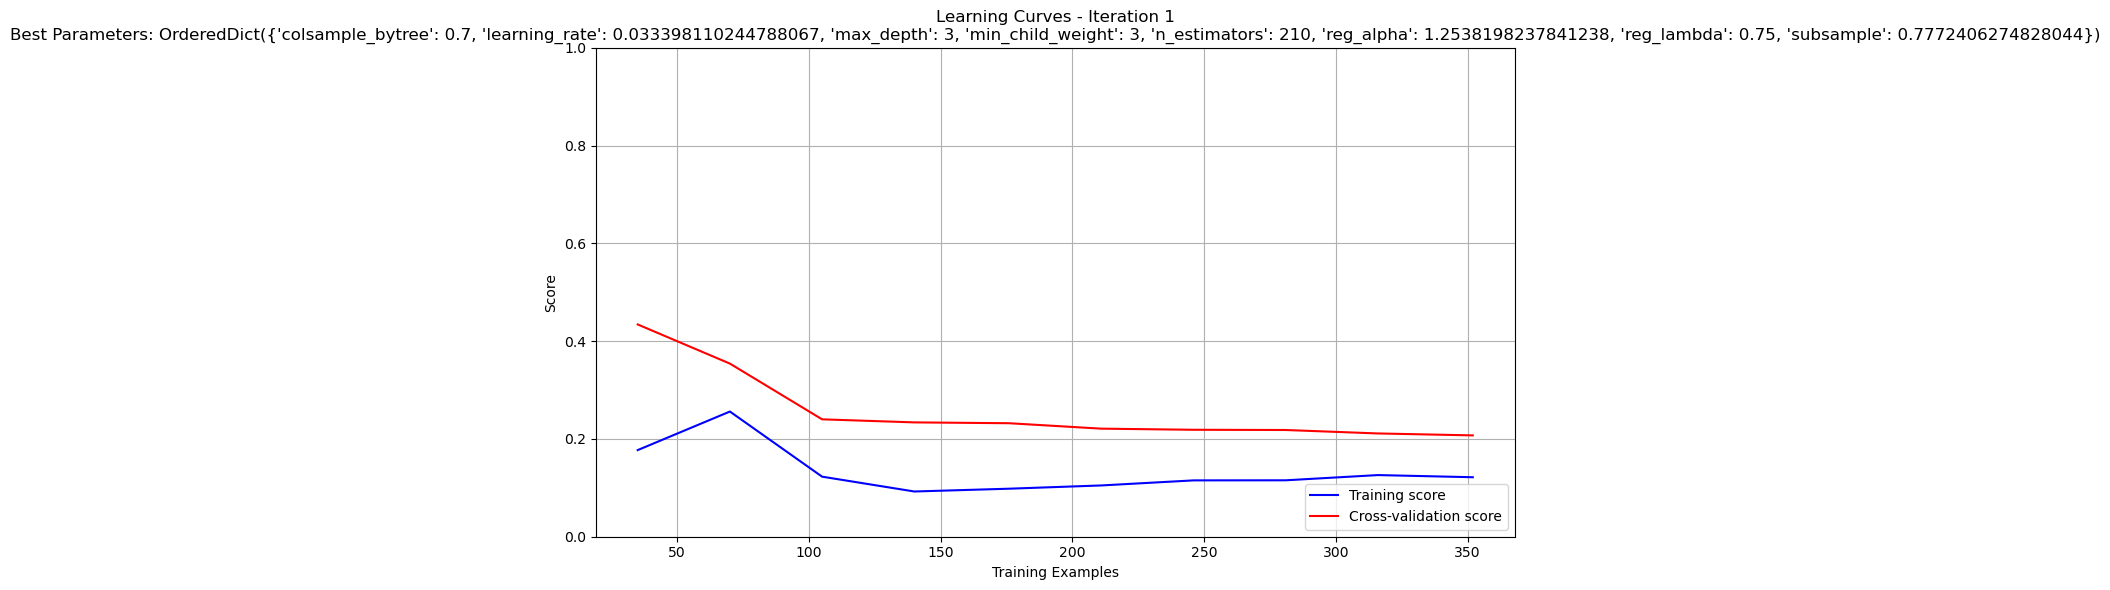

Recall Score:  0.7333333333333333


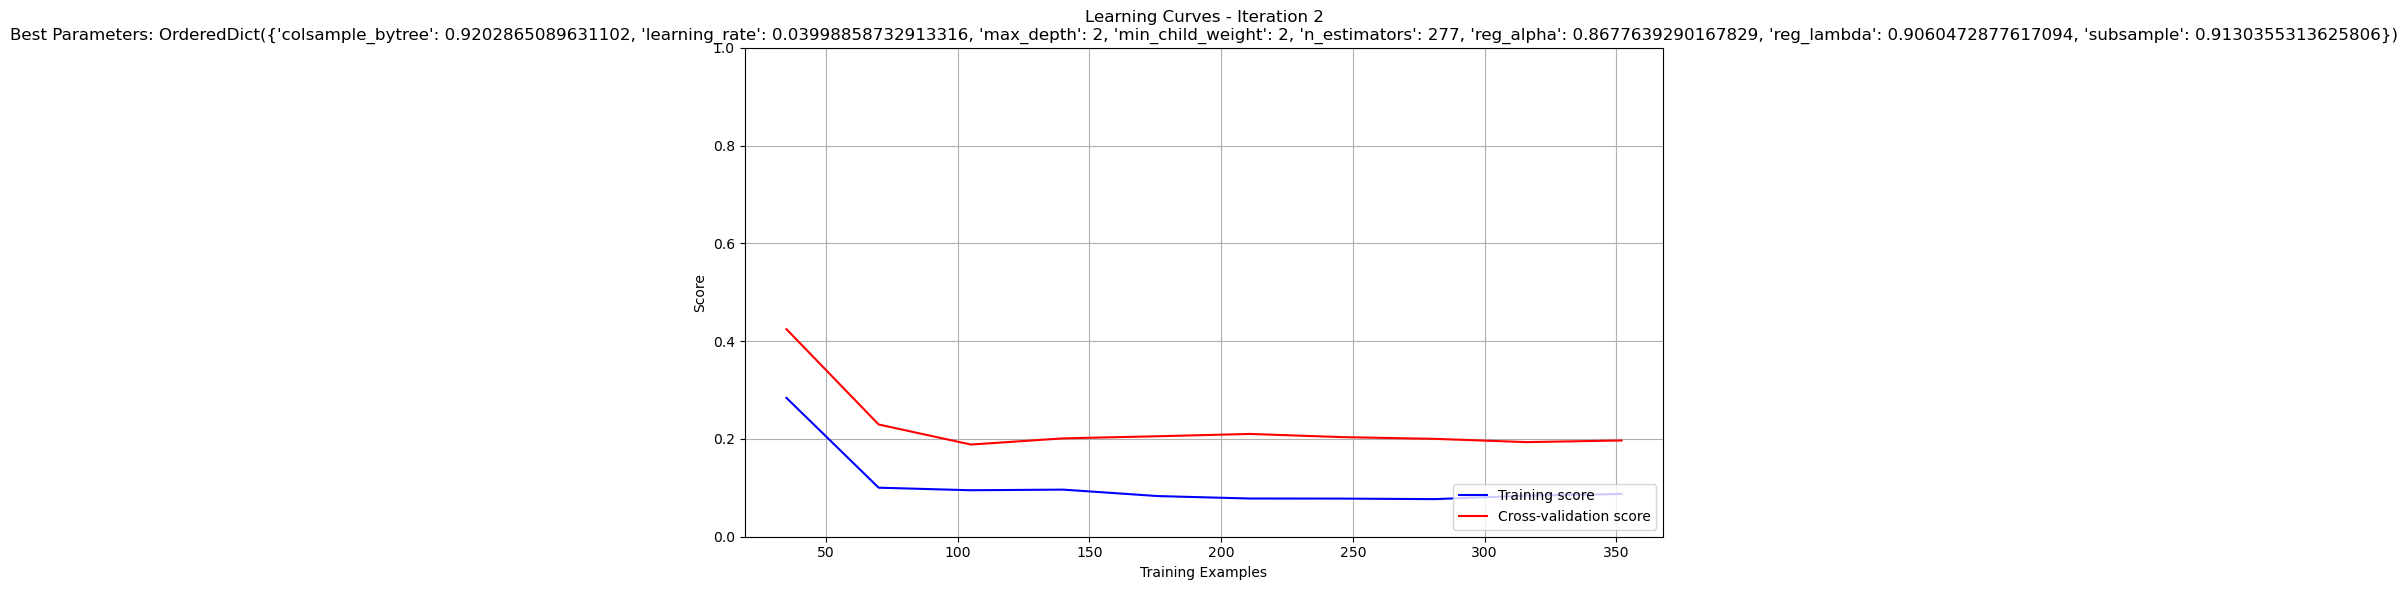

Recall Score:  0.8666666666666667
Average Accuracy: 0.9393939393939394
Average Precision: 0.8194444444444444
Average Recall: 0.8
Average F1 Score: 0.8013468013468013
Averaged Hyperparameters:
colsample_bytree      0.810143
learning_rate         0.036693
max_depth             2.500000
min_child_weight      2.500000
n_estimators        243.500000
reg_alpha             1.060792
reg_lambda            0.828024
subsample             0.845138
dtype: float64


In [51]:
cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(2):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("Recall Score: ", recall)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

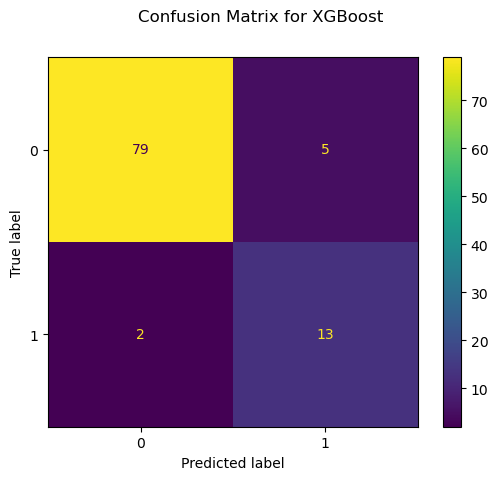

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [55]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.881640
ixG_per_game                 0.888284
iFF_per_game                 0.885369
iSCF_per_game                0.899731
iHDCF_per_game               0.736754
assists_per_game             0.768798
iCF_per_game                 0.878980
Rebounds Created_per_game    0.772109
time_on_ice_per_game         0.796677
dtype: float64


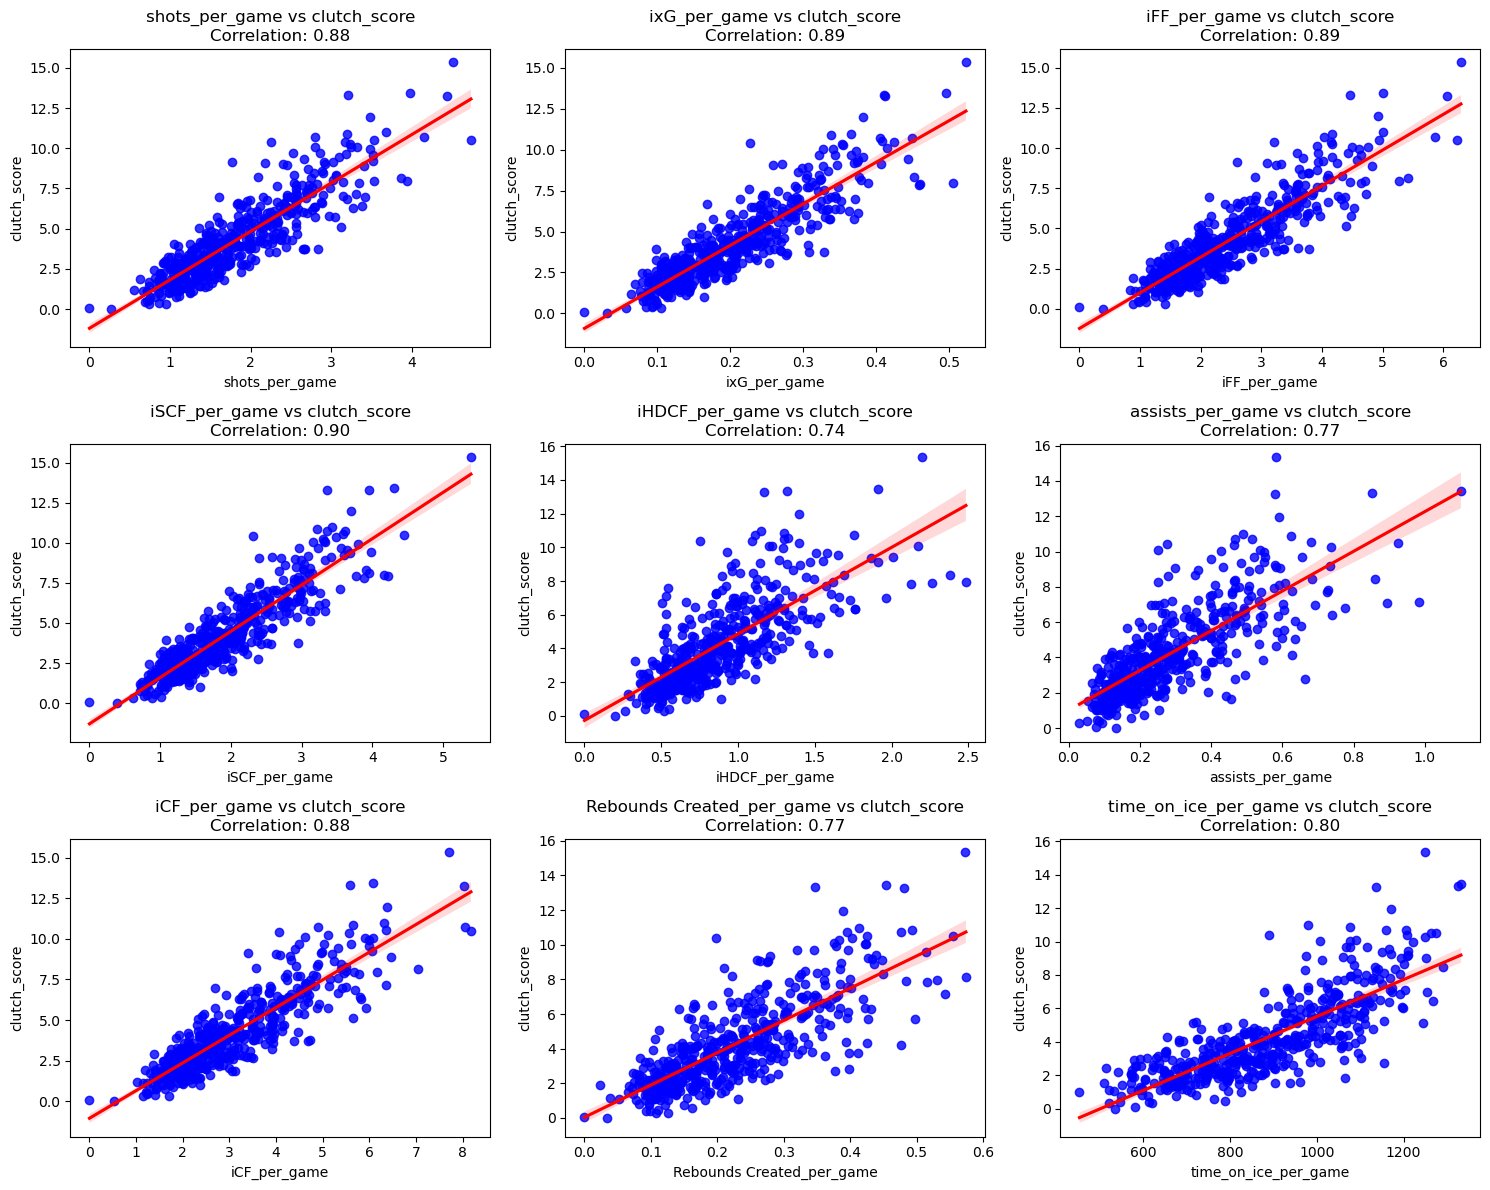

In [57]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

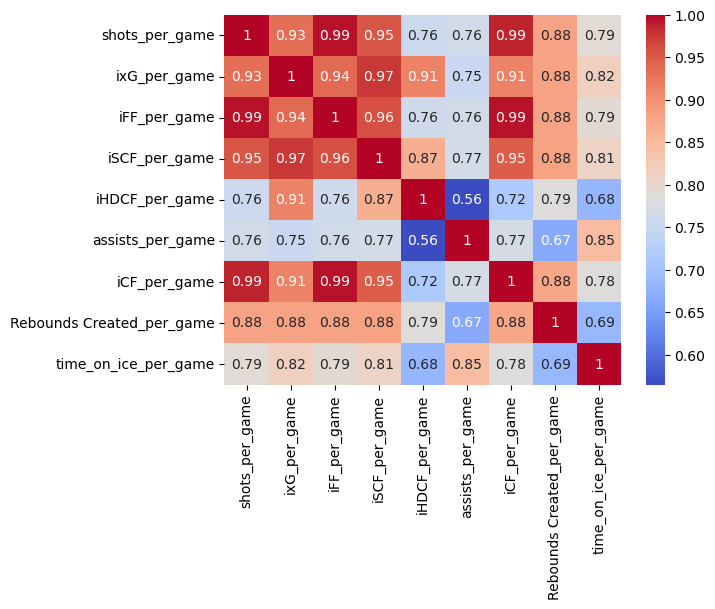

In [59]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

In [61]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.0985430571973192
RMSE:  1.048114047800772
MAE:  0.6385511525777501
R²:  0.857244009287033
Adjusted R²:  0.853880648249293


In [63]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')


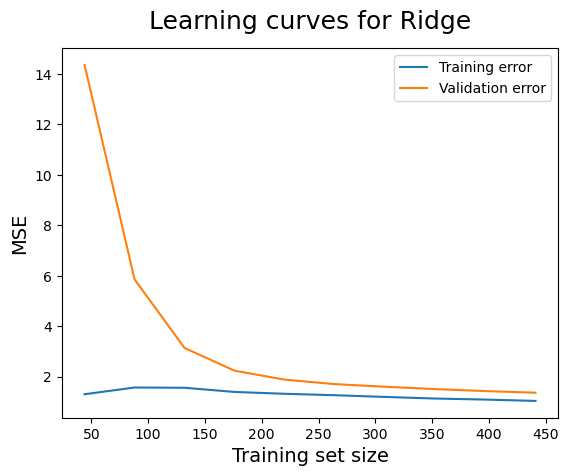

In [64]:
import matplotlib.pyplot as plt

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

In [67]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                    Player  Actual  Predicted     Error
246            Jakub Vrana   10.40   5.240299  5.159701
335        Auston Matthews   15.33  12.053156  3.276844
300            Roope Hintz    9.69   7.409661  2.280339
55           Jakub Voracek    2.80   4.818979  2.018979
60          Steven Stamkos    9.70   7.698033  2.001967
171         Filip Forsberg   10.06   8.211180  1.848820
117        Mikael Granlund    2.76   4.605667  1.845667
209       Andre Burakovsky    6.70   4.877988  1.822012
150         Mark Scheifele    9.02   7.312753  1.707247
269          Dakota Joshua    2.89   1.430867  1.459133
310           Jake DeBrusk    7.09   5.678172  1.411828
488         Wyatt Johnston    5.73   4.366322  1.363678
456          Cole Caufield    8.29   6.977353  1.312647
224              Bo Horvat    8.68   7.383484  1.296516
336           Wade Allison    4.13   2.863333  1.266667
107            Kevin Hayes    4.29   5.537551  1.247551
78           

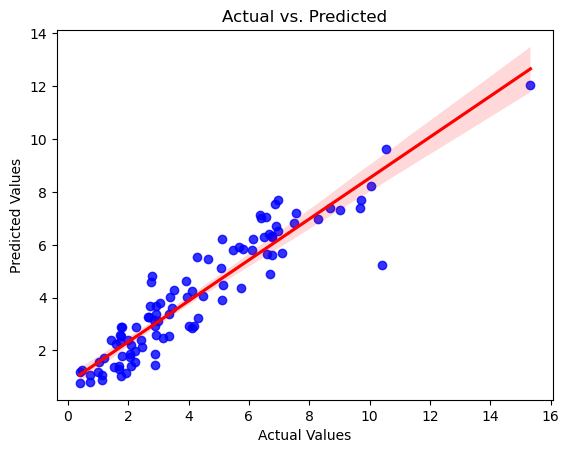

In [69]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

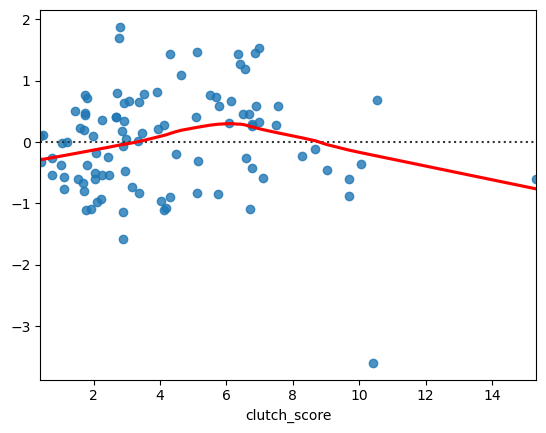

In [71]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

There are 40 influential points.
Outliers based on Cook's Distance:
                  Player  Actual  Predicted  Cook's Distance
335      Auston Matthews   15.33  12.771322         0.089624
284       Connor McDavid   13.44  12.232692         0.023743
240       Leon Draisaitl   13.33  10.268935         0.058680
254       David Pastrnak   13.27  10.785039         0.042046
321      Kirill Kaprizov   11.97   9.537709         0.014147
54        Max Pacioretty   10.98   8.990213         0.015717
400      Jason Robertson   10.87   7.922492         0.038332
291        Sebastian Aho   10.71   8.534895         0.014174
219     Nathan MacKinnon   10.49  11.853460         0.015769
246          Jakub Vrana   10.40   5.663728         0.042516
220    Aleksander Barkov   10.27   8.658559         0.008965
86         Chris Kreider   10.10   7.466307         0.041567
171       Filip Forsberg   10.06   8.224806         0.013881
362        Tage Thompson   10.05   7.618477         0.013721
300          Roop

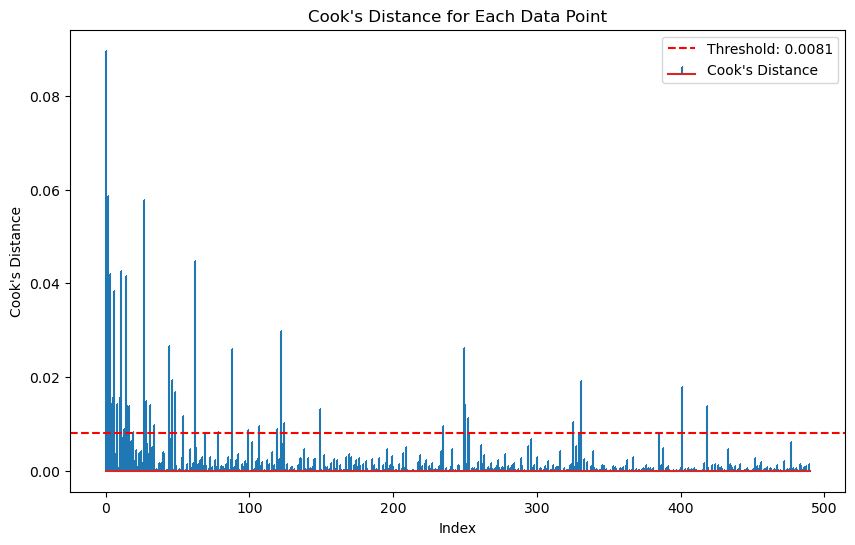

In [73]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


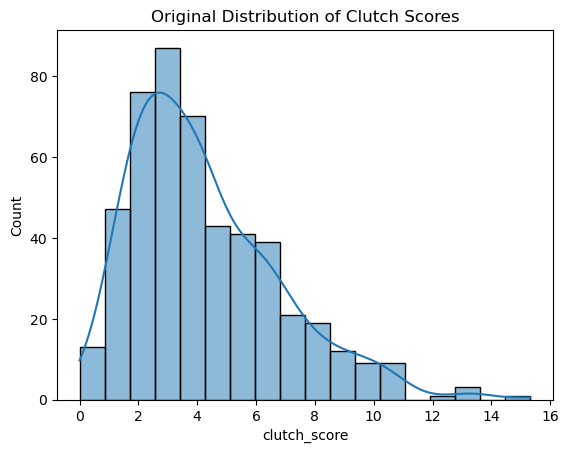

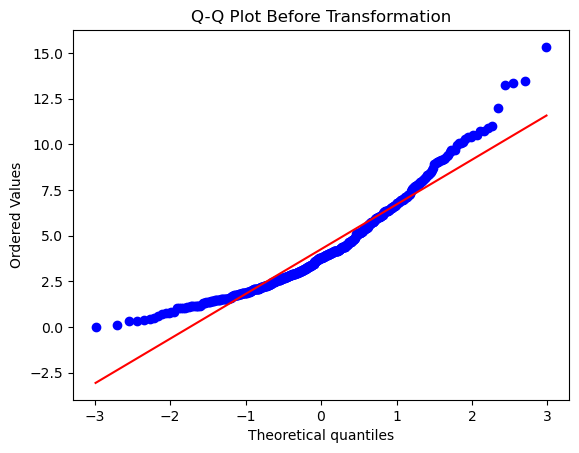

In [75]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()

stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

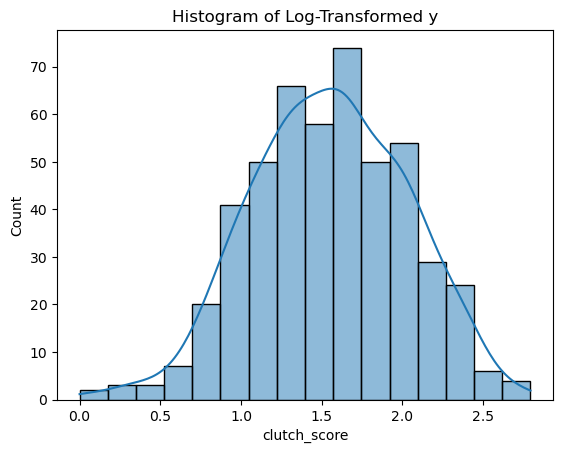

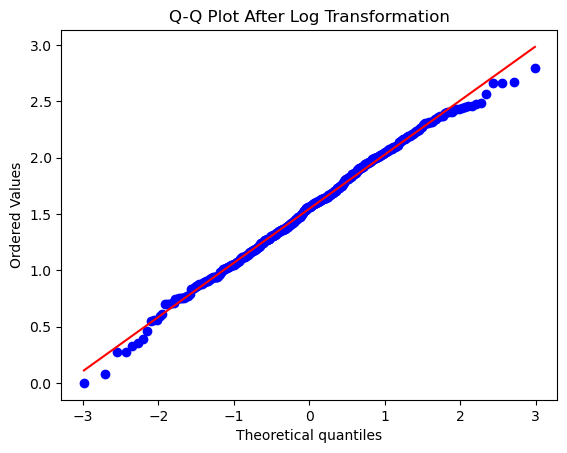

In [77]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

In [79]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

In [81]:
y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=42
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv_log = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.0419605110824888
RMSE:  0.20484264956909926
MAE:  0.13627948456777872
R²:  0.8514154385171769
Adjusted R²:  0.847914755131456


In [83]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                 Player    Actual  Predicted     Error
246         Jakub Vrana  2.433613   1.735949  0.697665
382     Jake Leschyshyn  0.329304   0.888308  0.559004
59           Jay Beagle  0.392042   0.920099  0.528057
185     Cedric Paquette  0.350657   0.751763  0.401106
269       Dakota Joshua  1.358409   0.987944  0.370466
209    Andre Burakovsky  2.041220   1.680116  0.361104
55        Jakub Voracek  1.335001   1.668194  0.333193
117     Mikael Granlund  1.324419   1.653727  0.329308
78        Alex Chiasson  1.642873   1.327467  0.315405
181       Teddy Blueger  1.011601   1.320222  0.308621
192        Jayson Megna  0.548121   0.854598  0.306477
182        Brock McGinn  1.615420   1.325647  0.289773
24          Darren Helm  0.887891   1.175414  0.287523
276          Jake Evans  1.026042   1.311607  0.285566
319        Denis Malgin  1.669592   1.391013  0.278579
367         Ross Colton  1.809927   1.531969  0.277958
300         Roope Hintz  2.369

There are 13 influential points.
Outliers based on Cook's Distance:
              Player    Actual  Predicted  Cook's Distance
246      Jakub Vrana  2.433613   1.836474         0.018264
490  Andrei Kuzmenko  2.316488   1.842127         0.019532
377       Mason Shaw  1.401183   1.048715         0.023923
269    Dakota Joshua  1.358409   0.968999         0.018994
474       Jack Quinn  1.316408   1.669466         0.015282
480    Cole Perfetti  1.108563   1.682969         0.025390
6       Ryan Getzlaf  1.040277   1.576280         0.022291
479  Quinton Byfield  0.698135   1.316591         0.028247
484        Nils Aman  0.463734   0.927868         0.022155
59        Jay Beagle  0.392042   0.881137         0.018261
382  Jake Leschyshyn  0.329304   0.896191         0.016835
197  Saku Maenalanen  0.270027   0.866111         0.018049
230    Ross Johnston  0.000000   0.361609         0.014974


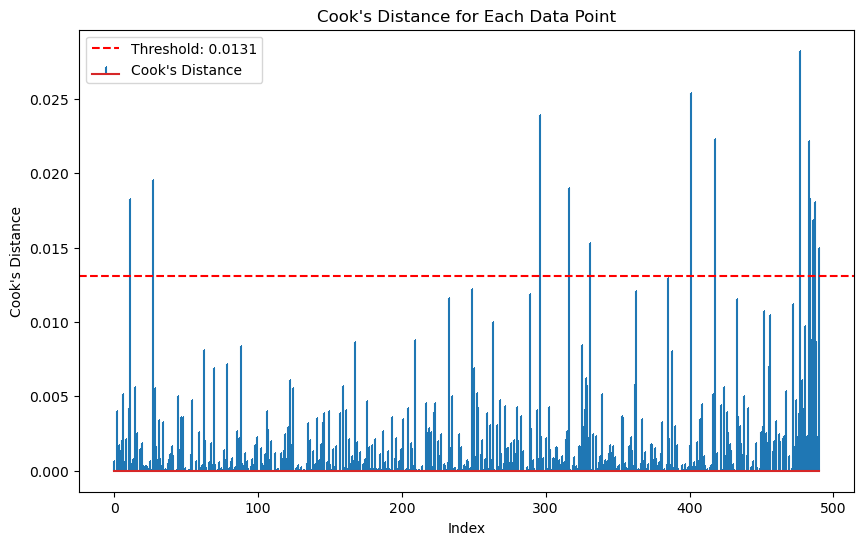

In [85]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

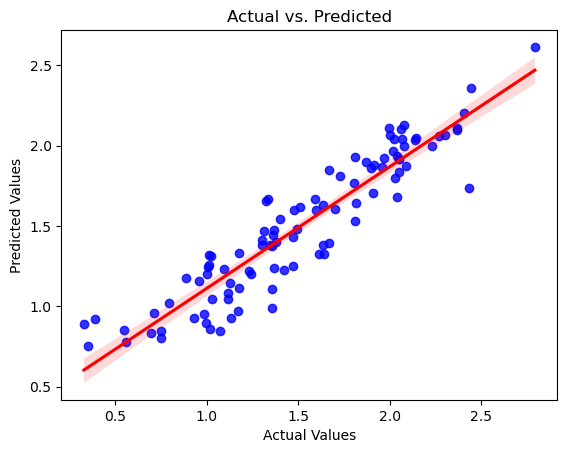

In [87]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

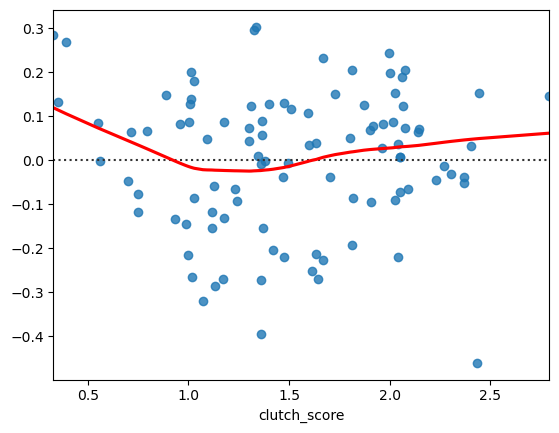

In [89]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

In [430]:
all_seasons = []

for season in range(2023, 2025):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
Successfully fetched data for season 2024-2025
     playerId      skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600          Ryan Suter            D           97       18        0   
1     8470604         Jeff Carter            C           72        4        0   
2     8470610         Zach Parise            L           30        5        0   
3     8470613         Brent Burns            D           96       38        0   
4     8470621         Corey Perry            R           69       11        0   
..        ...                 ...          ...          ...      ...      ...   
954   8484779       Jett Luchanko            C            4        0        0   
955   8484801   Macklin Celebrini            C            5        1        0   
956   8484911         Collin Graf            R            7        2        0   
957   8484958     Maxim Tsyplakov            R           15        7        0   
958   8485105  

In [431]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 20)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [434]:
start_season = "20232024"
end_season = "20242025"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [436]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [437]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 20]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [438]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [439]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [440]:
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)

In [446]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [448]:
merged_clutch_goals_prediction['clutch_score'] = 0.3 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals_prediction['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals_prediction['ot_goals_per_game']

In [450]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
272,Auston Matthews,16.49,1.0
184,Sam Reinhart,15.46,2.0
198,David Pastrnak,12.96,3.0
261,Kirill Kaprizov,12.78,4.0
256,Artemi Panarin,12.32,5.0
185,Leon Draisaitl,12.08,6.0
223,Kyle Connor,11.88,7.0
206,Brayden Point,11.61,8.0
98,Nikita Kucherov,11.47,9.0
191,Dylan Larkin,11.34,10.0


In [452]:
merged_clutch_goals_prediction = merged_clutch_goals_prediction.fillna(0)
null_rows = merged_clutch_goals_prediction[merged_clutch_goals_prediction.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, Rush Attempts, iCF, Rebounds Created, ot_goals_per_game, regulation_game_winning_per_game, assists_per_game, goals_up_by_one_per_game, goals_down_by_one_per_game, goals_when_tied_per_game, shots_per_game, ixG_per_game, iFF_per_game, iSCF_per_game, iHDCF_per_game, iCF_per_game, Rebounds Created_per_game, clutch_score, clutch_score_rank]
Index: []

[0 rows x 36 columns]


In [454]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

In [456]:
X_scaled = StandardScaler().fit_transform(X_adjusted)
X_scaled = np.nan_to_num(X_scaled, nan=0)

epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

y_pred = ridge_cv_log.predict(X_log)

In [458]:
len(X_log)

485

In [460]:
len(y_pred)

485

In [462]:
merged_clutch_goals_prediction

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,goals_up_by_one,...,goals_when_tied_per_game,shots_per_game,ixG_per_game,iFF_per_game,iSCF_per_game,iHDCF_per_game,iCF_per_game,Rebounds Created_per_game,clutch_score,clutch_score_rank
272,8479318,Auston Matthews,C,94,44,3,8,1253.60915,5,15.0,...,0.223404,4.521277,0.562447,6.638298,5.457447,2.393617,8.574468,0.851064,16.49,1.0
184,8477933,Sam Reinhart,C,97,49,3,11,1211.82720,8,17.0,...,0.278351,2.804124,0.450515,4.268041,3.484536,1.835052,5.319588,0.556701,15.46,2.0
198,8477956,David Pastrnak,R,98,71,1,6,1183.92145,5,14.0,...,0.224490,4.571429,0.452551,6.346939,4.040816,1.346939,8.602041,0.724490,12.96,3.0
261,8478864,Kirill Kaprizov,L,90,69,2,10,1312.47330,8,9.0,...,0.211111,3.588889,0.489667,5.366667,4.100000,1.722222,7.655556,0.744444,12.78,4.0
256,8478550,Artemi Panarin,L,95,82,1,6,1187.06705,5,9.0,...,0.189474,3.652632,0.353789,5.284211,3.452632,0.778947,7.894737,0.557895,12.32,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,8481543,Nikita Alexandrov,C,23,2,0,0,511.56520,0,0.0,...,0.000000,0.652174,0.048261,0.826087,0.478261,0.217391,1.086957,0.043478,0.00,0.0
412,8481617,Vasily Podkolzin,R,34,5,0,0,688.88945,0,0.0,...,0.000000,1.176471,0.124706,1.735294,1.323529,0.647059,2.176471,0.205882,0.00,0.0
450,8482177,Marat Khusnutdinov,C,31,5,0,0,740.74580,0,0.0,...,0.000000,0.354839,0.055161,0.806452,0.645161,0.290323,1.064516,0.000000,0.00,0.0
454,8482451,Mikael Pyyhtia,L,31,2,0,0,815.04615,0,0.0,...,0.000000,0.967742,0.085484,1.387097,0.870968,0.419355,1.870968,0.064516,0.00,0.0


In [464]:
len(y_pred)

485

In [466]:
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred
merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 
merged_clutch_goals_prediction['predicted_clutch_score_rank']  = merged_clutch_goals_prediction['predicted_clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction.sort_values('predicted_clutch_score_rank', inplace = True)

In [468]:
merged_clutch_goals_prediction['predicted_clutch_score_percentile'] = merged_clutch_goals_prediction['predicted_clutch_score'].rank(pct = True) * 100
merged_clutch_goals_prediction['log_score_percentile'] = merged_clutch_goals_prediction['log'].rank(pct = True)  * 100
merged_clutch_goals_prediction['predicted_clutch_score_percentile'] = merged_clutch_goals_prediction['predicted_clutch_score_percentile'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['log_score_percentile'] = merged_clutch_goals_prediction['log_score_percentile'].apply(lambda x: round(x, 2))


In [470]:
merged_clutch_goals_prediction[['Player', 'predicted_clutch_score_rank', 'clutch_score_rank', 'predicted_clutch_score_percentile', 'log_score_percentile']].head(20)

,Player,predicted_clutch_score_rank,clutch_score_rank,predicted_clutch_score_percentile,log_score_percentile
272,Auston Matthews,1.0,1.0,100.00,100.00
165,Nathan MacKinnon,2.0,13.0,99.79,97.53
198,David Pastrnak,3.0,3.0,99.59,99.59
261,Kirill Kaprizov,4.0,4.0,99.38,99.38
146,Jake Guentzel,5.0,88.0,99.18,81.86
361,Brady Tkachuk,6.0,34.0,98.97,93.20
98,Nikita Kucherov,7.0,9.0,98.76,98.35
226,Connor McDavid,8.0,31.0,98.56,93.81
404,Jack Hughes,9.0,27.0,98.35,94.64
124,Filip Forsberg,10.0,11.0,98.14,97.94


In [472]:
len(y_log)

485

There are 19 influential points.
Outliers based on Cook's Distance:
                  Player    Actual  Predicted  Cook's Distance
192         Sonny Milano  2.020222   1.057588         0.024486
305      Michael Carcone  1.991976   1.121708         0.018689
477         Shane Wright  1.958685   1.321468         0.022948
455           Matt Rempe  1.098612   0.555061         0.033370
140     Kurtis MacDermid  0.854415   0.167152         0.030148
54   Nicolas Deslauriers  0.000000   0.618982         0.014872
64         Tyler Pitlick  0.000000   0.801783         0.015745
116       Brendan Gaunce  0.000000   0.938819         0.022019
164      Zachary Sanford  0.000000   1.031675         0.028133
253       Austin Czarnik  0.000000   0.717250         0.015463
286         Givani Smith  0.000000   0.579005         0.015995
302          Oskar Steen  0.000000   0.682504         0.013150
303     Matthew Phillips  0.000000   0.758101         0.030466
324      Jonas Rondbjerg  0.000000   1.129782     

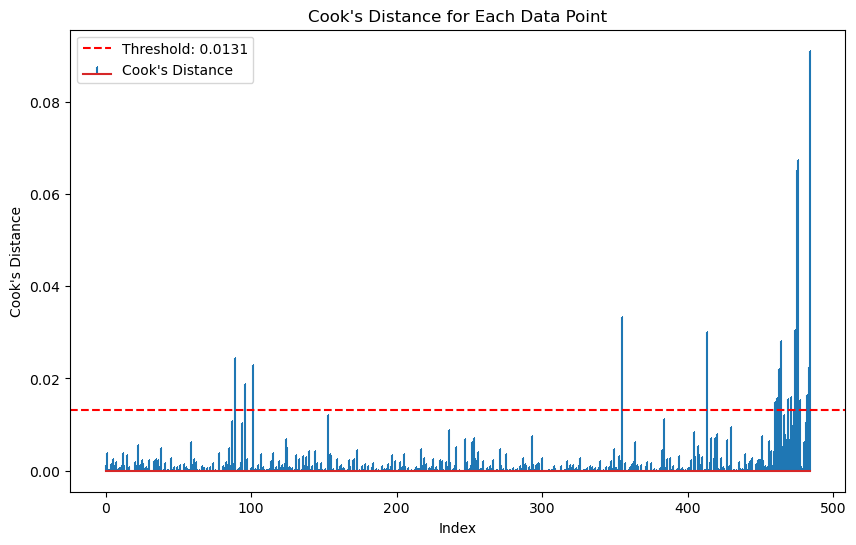

In [478]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

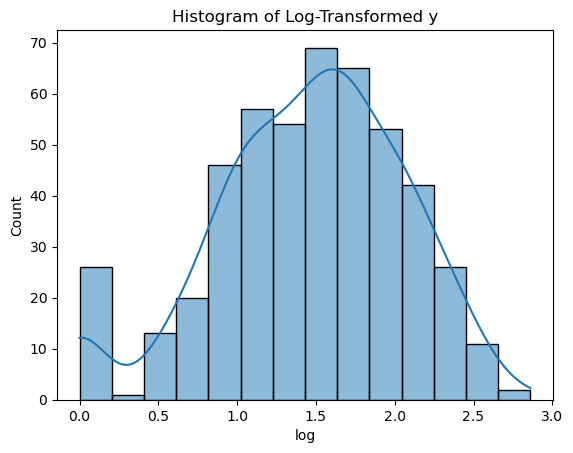

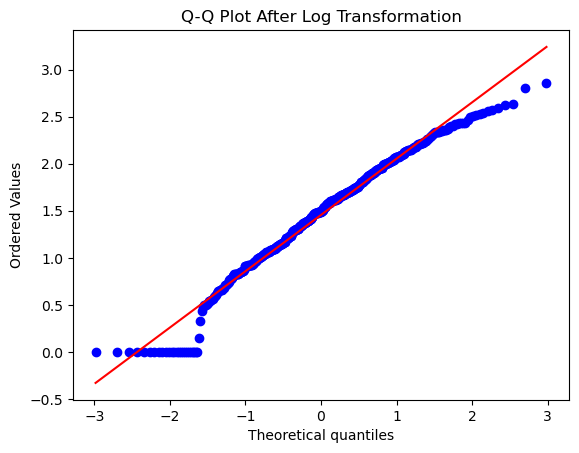

In [486]:
sns.histplot(merged_clutch_goals_prediction['log'], kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(merged_clutch_goals_prediction['log'], dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

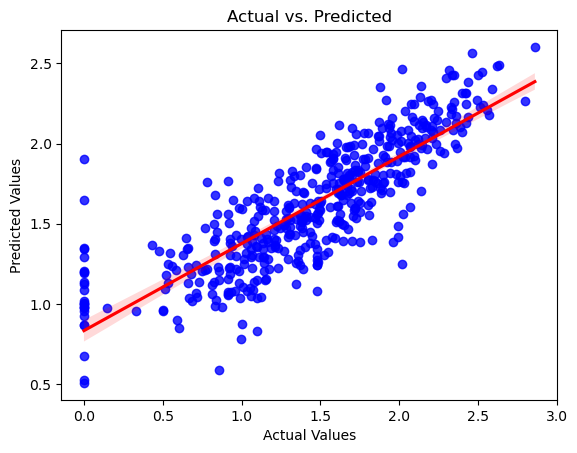

In [492]:
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log'], y=merged_clutch_goals_prediction['predicted_clutch_score'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()